# Proximity and Accessibility analysis using Pandana

## Set up environment

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # disable Pandana multithreading 
os.environ["USE_PYGEOS"] = "0"  # suppress geopandas warning

import pandana
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

## Data Loading

We will load data from the following path on Spider: `/project/stursdat/Data/ScalableGIS/Part2/data_9_cities`. We use the `pathlib.Path` library to handle the path object.

In [2]:
from pathlib import Path

data_folder = Path("data")

# list_cities = ["Delft", "Arnhem"] # For debugging
list_cities = [ "Arnhem", "Breda", "Nijmegen", "Delft", "Amersfoort", "Leiden", "Enschede", "Deventer", "Gouda"]


In [3]:
import dask.bag as db
bags = db.from_sequence(list_cities, npartitions=9)

In [4]:
def load_one_city(city, data_folder):
    dir_city = data_folder / city
    nodes = gpd.read_file(next(dir_city.glob('*nodes*.shp'))) # We know there is only one result, so we use the "next" 
    edges = gpd.read_file(next(dir_city.glob('*edges*.shp')))
    parks = gpd.read_file(next(dir_city.glob('*parks*.shp')))
    buildings = gpd.read_file(next(dir_city.glob('*buildings*.shp')))

    # Return a dictionary of the city
    return {"nodes": nodes, "edges": edges, "parks":parks, "buildings": buildings}

In [5]:
# Load shape files to memory
gdf_cities = bags.map(load_one_city, data_folder)

In [6]:
import dask

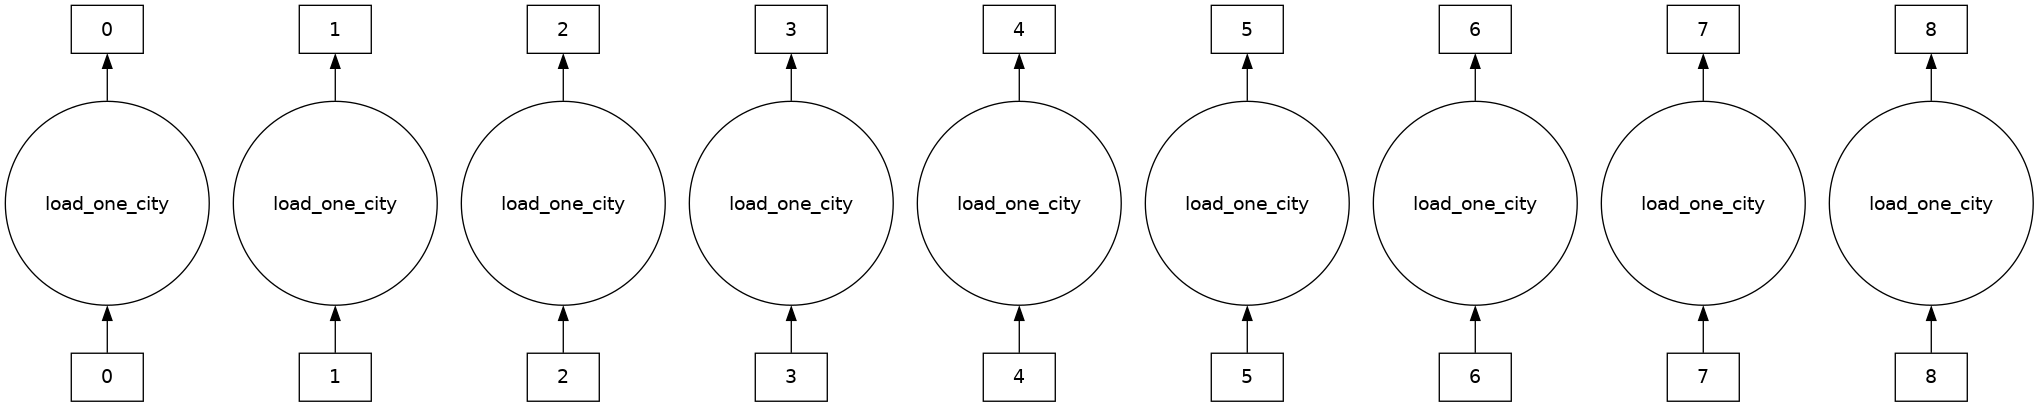

In [7]:
dask.visualize(gdf_cities)

In [8]:
gdf_one_city = gdf_cities.take(1)
gdf_one_city

In [9]:
def build_network_one_city(gdf_city):
    # Unpack dictionary
    nodes = gdf_city["nodes"]
    edges = gdf_city["edges"]
    parks = gdf_city["parks"]

    # Set indexes for nodes and edges
    nodes = nodes.set_index("osmid", drop=False)
    edges = edges.set_index(["u", "v"], drop=False)

    # setup a network
    network = pandana.Network(
        node_x=nodes["x"], 
        node_y=nodes["y"], 
        edge_from=edges["u"], 
        edge_to=edges["v"], 
        edge_weights=edges[["length"]],
    )

    network.set_pois(
        category="parks",
        maxdist=1000,
        maxitems=25,
        x_col=parks.centroid.x,
        y_col=parks.centroid.y,
    )
    
    return network

## Proximity analysis 

In [10]:
def proximity_analysis_one_city(gdf_city):
    # build network
    network = build_network_one_city(gdf_city)    

    # for all nodes, find 3 closest parks within 800m
    proximity = network.nearest_pois(
        distance=800,
        category="parks",
        num_pois=3,
        include_poi_ids=False
    )

    return proximity

In [11]:
# bags = db.from_sequence(gdf_cities, npartitions=2)
proximity_cities = gdf_cities.map(proximity_analysis_one_city)

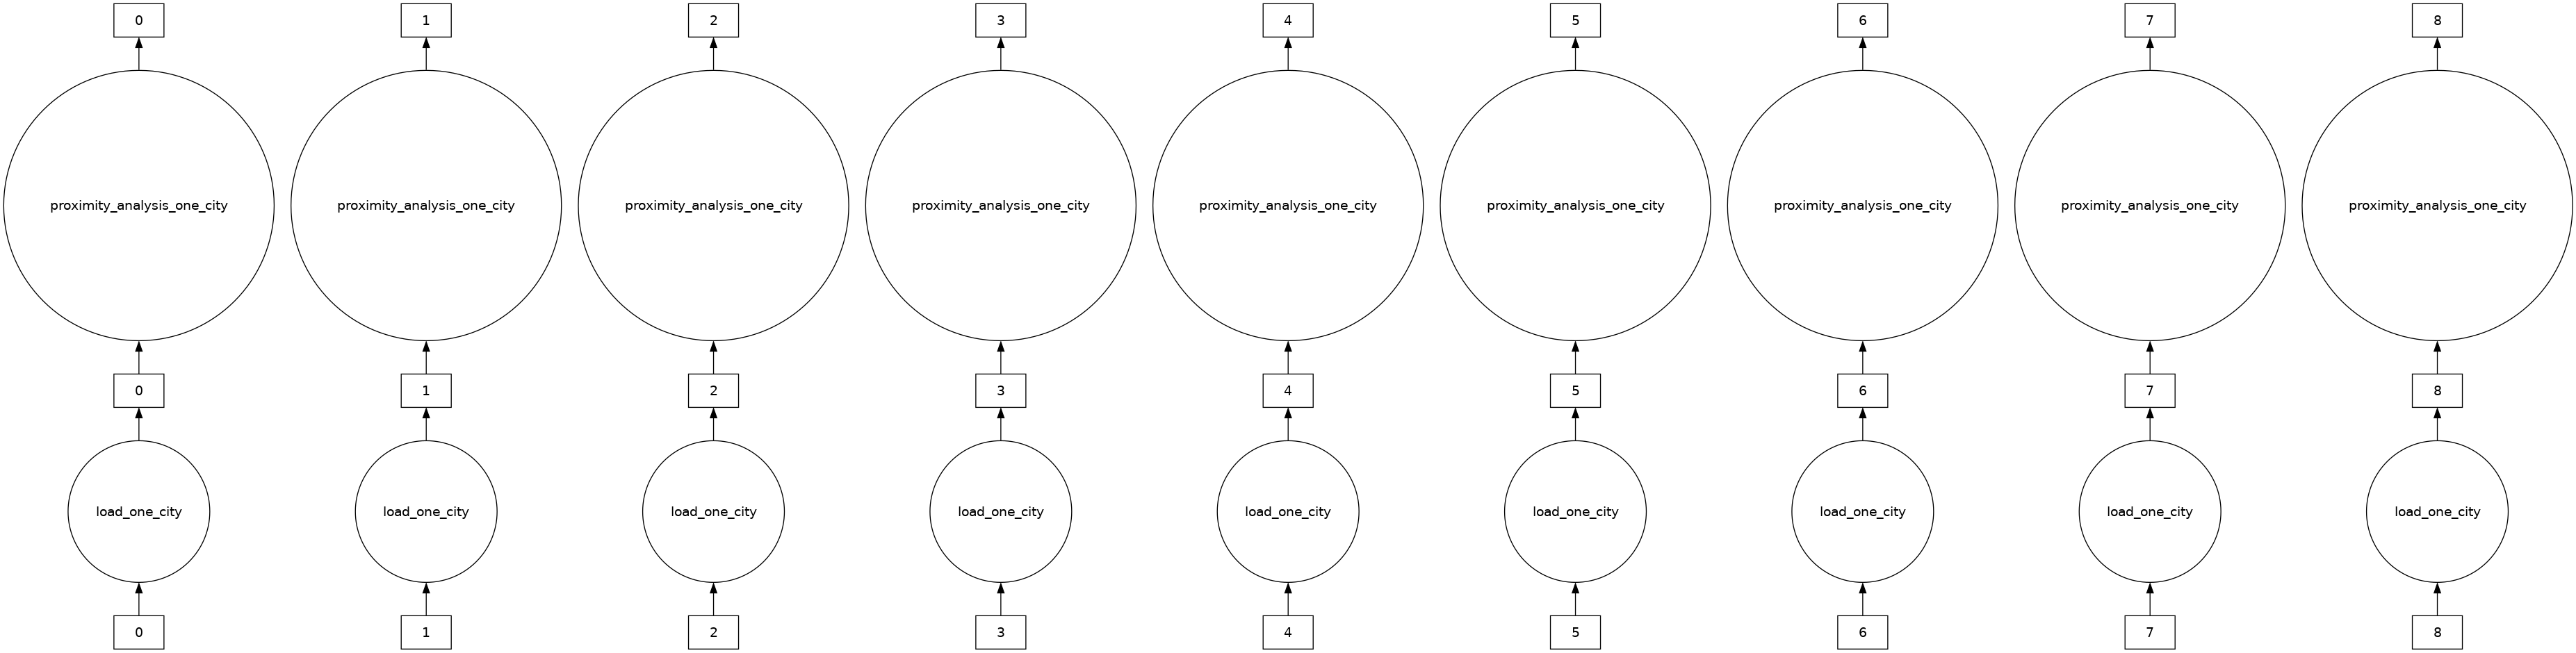

In [12]:
dask.visualize(proximity_cities)

## Accessibility analysis

In [13]:
def accessibility_analysis_one_city(gdf_city):

    # build network
    network = build_network_one_city(gdf_city)

    # Unpack dictionary
    parks = gdf_city["parks"]
    buildings = gdf_city["buildings"]

    # add target points to network
    node_ids = network.get_node_ids(parks.centroid.x, y_col=parks.centroid.y)
    network.set(node_ids, name="parks")

    # for all nodes, find how many parks fall within 800m
    accessibility = network.aggregate(
        distance=800,
        type="count",
        name="parks"
    )

    # assign accessibility of buildings using closest nodes 
    node_ids = network.get_node_ids(
        x_col=buildings.centroid.x, 
        y_col=buildings.centroid.y
    )
    buildings["accessibility"] = node_ids.map(accessibility.to_dict())

    return [accessibility, buildings]

In [14]:
# bags = db.from_sequence(gdf_cities, npartitions=2)
accessibility_cities = gdf_cities.map(accessibility_analysis_one_city)

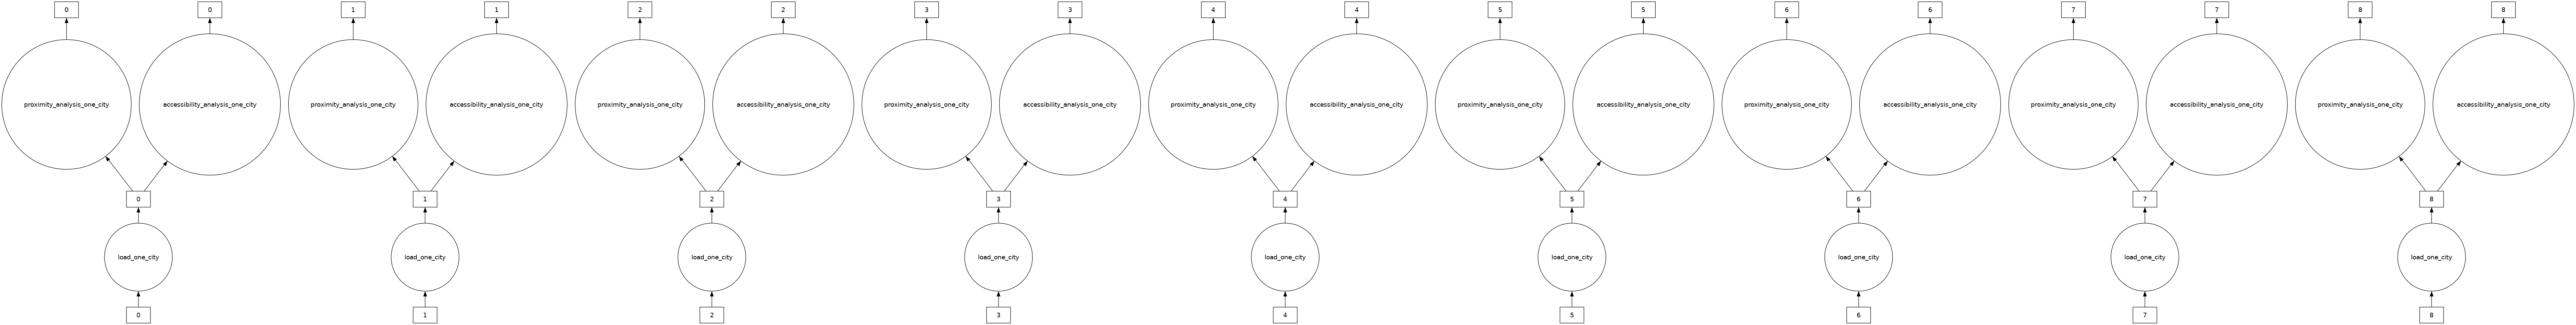

In [15]:
dask.visualize([proximity_cities, accessibility_cities])

In [17]:
results = dask.compute([proximity_cities, accessibility_cities])

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 5969
Setting CH edge vector of size 16672
Range graph removed 17222 edges of 33344
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 5969
Setting CH edge vector of size 16672
Range graph removed 17222 edges of 33344
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 11729
Setting CH edge vector of size 33170
Range graph removed 34568 edges of 66340
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 11729
Setting CH edge vector of size 33170
Range graph removed 34568 edges of 66340
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 

In [22]:
proximity_cities = results[0][0]
accessibility_cities = results[0][1]

In [25]:
# visualize nodes using accessibility
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for ax, city, gdf, accessibility in zip(axes.flatten(), list_cities, gdf_cities, accessibility_cities):
    parks = gdf["parks"]
    nodes = gdf["nodes"]
    parks.plot(
        ax=ax,
        color="green"
    )
    ax.set_title('{}: Parks within 800m'.format(city))
    ax.scatter(
        nodes["x"], 
        nodes["y"], 
        c=accessibility[0], 
        s=1, 
        cmap='autumn', 
        norm=matplotlib.colors.LogNorm()
    )

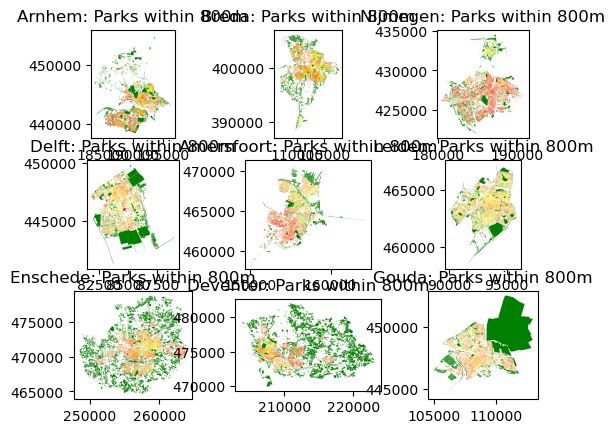

In [24]:
# visualize buildings using accessibility
fig, axes = plt.subplots(3, 3)
for ax, city, gdf, accessibility in zip(axes.flatten(), list_cities, gdf_cities, accessibility_cities):
    parks = gdf["parks"]
    buildings = accessibility[1]

    ax.set_title('{}: Parks within 800m'.format(city))
    
    parks.plot(
    ax=ax,
    color="green"
    )
    
    buildings.plot(
        ax=ax,
        column="accessibility",  
        cmap="autumn",
        norm=matplotlib.colors.LogNorm(),
        figsize=(10,8),
    )